# Convergence of Pipeline (THIS TIME WITH CHERRIES)

The goal of this experiment is to determine how fast our estimator saturates, as a function of the number of protein families we train on. We explore the convergence of 4 different estimators:

With simulated data:

1. The pipeline with access to the ground truth trees and ancestral states.
2. The pipeline with access to ground truth trees only (i.e. without ancestral states)
3. The full pipeline.

With real data:

4. The full pipeline. (This is the only thing we can do on real data!)

In [1]:
experiment_rootdir = "convergence_of_pipeline_cherries"
n_process = 32
max_families_list = [1, 2, 4, 8, 16, 32]#, 64, 128, 256, 512, 1024]
SRC_DIR = "../../"

# Imports

In [2]:
import sys
sys.path.append(SRC_DIR)
import os
import time
import logging
import numpy as np
import pandas as pd
import Phylo_util

if not os.path.exists(experiment_rootdir):
    os.makedirs(experiment_rootdir)

def init_logger():
    logger = logging.getLogger('phylo_correction')
    logger.setLevel(logging.DEBUG)
    fmt_str = "[%(asctime)s] - %(name)s - %(levelname)s - %(message)s"
    formatter = logging.Formatter(fmt_str)

    consoleHandler = logging.StreamHandler(sys.stdout)
    consoleHandler.setFormatter(formatter)
    logger.addHandler(consoleHandler)

    fileHandler = logging.FileHandler(f"{experiment_rootdir}/log")
    fileHandler.setFormatter(formatter)
    logger.addHandler(fileHandler)

init_logger()

# For each number of protein families, run each of the 4 estimators

In [3]:
from src.pipeline import Pipeline
from src.end_to_end_simulation import EndToEndSimulator
from collections import defaultdict

def run_experiment_and_return_learned_rate_matrices():
    learned_rate_matrices = defaultdict(dict)
    for max_families in max_families_list:
        pipeline = Pipeline(
            outdir=f"{experiment_rootdir}/max_families_{max_families}/pipeline",
            max_seqs=1024,
            max_sites=1024,
            armstrong_cutoff=8.0,
            rate_matrix=f'{SRC_DIR}input_data/synthetic_rate_matrices/WAG_FastTree.txt',
            n_process=32,
            expected_number_of_MSAs=15051,
            max_families=max_families,
            a3m_dir=f'{SRC_DIR}input_data/a3m',
            pdb_dir=f'{SRC_DIR}input_data/pdb',
            use_cached=True,
            num_epochs=2000,
            device='cpu',
            center=0.06,
            step_size=0.1,
            n_steps=50,
            keep_outliers=False,
            max_height=1000.0,
            max_path_height=1000,
            precomputed_contact_dir=None,
            precomputed_tree_dir=None,
            precomputed_maximum_parsimony_dir=None,
            edge_or_cherry="cherry",
        )
        pipeline.run()
        learned_rate_matrices['real_data'][max_families] = pipeline.get_learned_Q1()

        end_to_end_simulator = EndToEndSimulator(
            outdir=f"{experiment_rootdir}/max_families_{max_families}/end_to_end_simulator",
            pipeline=pipeline,
            simulation_pct_interacting_positions=0.0,
            Q1_ground_truth=f"{SRC_DIR}input_data/synthetic_rate_matrices/WAG_matrix.txt",
            Q2_ground_truth=f"{SRC_DIR}input_data/synthetic_rate_matrices/Q2_uniform_constrained.txt",
            fast_tree_rate_matrix=f'{SRC_DIR}input_data/synthetic_rate_matrices/WAG_FastTree.txt',
            simulate_end_to_end=True,
            simulate_from_trees_wo_ancestral_states=True,
            simulate_from_trees_w_ancestral_states=True,
            use_cached=True,
        )
        end_to_end_simulator.run()
        learned_rate_matrices['w_ancestral_states'][max_families] = end_to_end_simulator.pipeline_on_simulated_data_from_trees_w_ancestral_states.get_learned_Q1()
        learned_rate_matrices['wo_ancestral_states'][max_families] = end_to_end_simulator.pipeline_on_simulated_data_from_trees_wo_ancestral_states.get_learned_Q1()
        learned_rate_matrices['end_to_end'][max_families] = end_to_end_simulator.pipeline_on_simulated_data_end_to_end.get_learned_Q1()
    return learned_rate_matrices

learned_rate_matrices = run_experiment_and_return_learned_rate_matrices()

*************** #families = 1 ***************


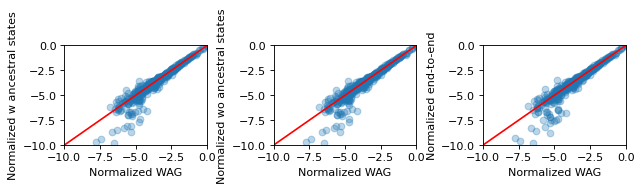

*************** #families = 2 ***************


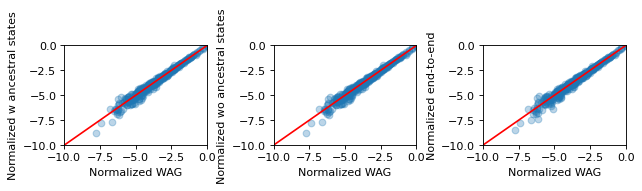

*************** #families = 4 ***************


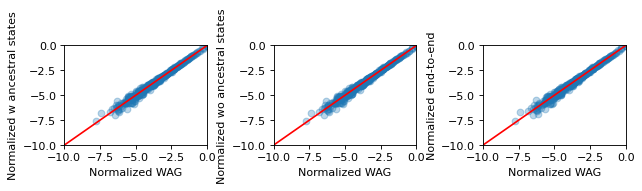

*************** #families = 8 ***************


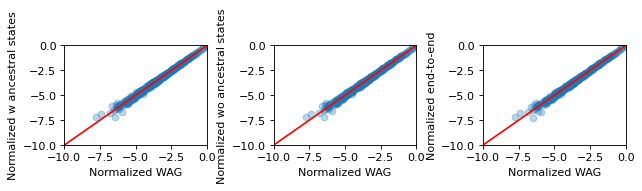

*************** #families = 16 ***************


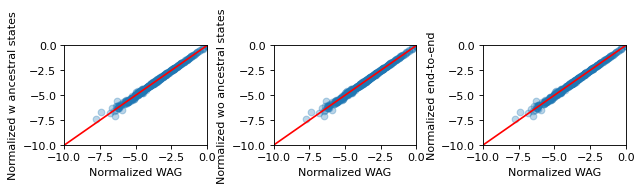

*************** #families = 32 ***************


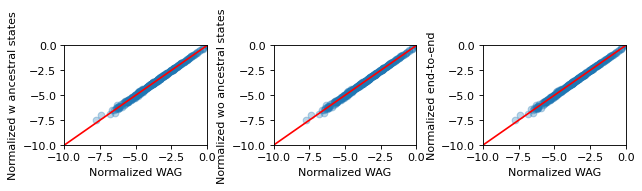

In [4]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import Phylo_util

def normalized(Q):
    pi = Phylo_util.solve_stationery_dist(Q)
    mutation_rate = pi @ -np.diag(Q)
    return Q / mutation_rate

def log_log_plot(Q_true, Q_true_name, Q_pred, Q_pred_name, normalize=False):
    if normalize:
        plt.scatter(np.log(np.abs(normalized(Q_true))), np.log(np.abs(normalized(Q_pred))), alpha=0.3)
        plt.xlabel(f'Normalized {Q_true_name}')
        plt.ylabel(f'Normalized {Q_pred_name}')
    else:
        plt.scatter(np.log(np.abs(Q_true)), np.log(np.abs(Q_pred)), alpha=0.3)
        plt.xlabel(f'{Q_true_name}')
        plt.ylabel(f'{Q_pred_name}')
    plt.xlim([-10, 0])
    plt.ylim([-10, 0])
    plt.plot([-10, 0], [-10, 0], color='r')

def plot_convergence_to_WAG_for_simulated_data():
    # For the simulated data, plot the ground truth (WAG) against the estimates.
    WAG_matrix = np.array(pd.read_csv(f"{SRC_DIR}input_data/synthetic_rate_matrices/WAG_matrix.txt", sep="\t", index_col=0))
    for max_families in max_families_list:
        print("*" * 15 + f" #families = {max_families} " + "*" * 15)
        for normalize in [True]:
            figure(figsize=(8, 2), dpi=80)
            plt.subplot(1, 3, 1)
            log_log_plot(WAG_matrix, "WAG", learned_rate_matrices['w_ancestral_states'][max_families], "w ancestral states", normalize=normalize)
            plt.subplot(1, 3, 2)
            log_log_plot(WAG_matrix, "WAG", learned_rate_matrices['wo_ancestral_states'][max_families], "wo ancestral states", normalize=normalize)
            plt.subplot(1, 3, 3)
            log_log_plot(WAG_matrix, "WAG", learned_rate_matrices['end_to_end'][max_families], "end-to-end", normalize=normalize)
            plt.tight_layout()
            plt.show()

plot_convergence_to_WAG_for_simulated_data()

*************** #families = 1 ***************


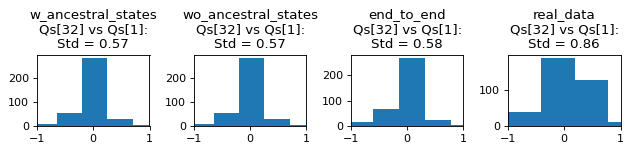

*************** #families = 2 ***************


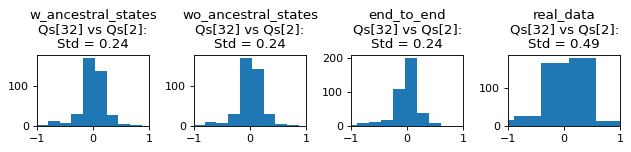

*************** #families = 4 ***************


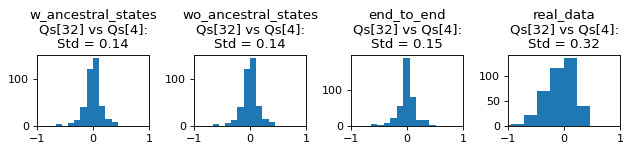

*************** #families = 8 ***************


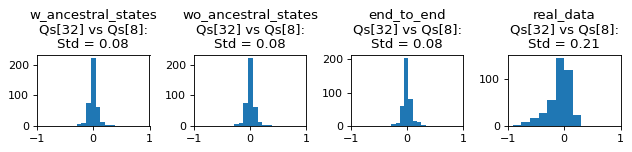

*************** #families = 16 ***************


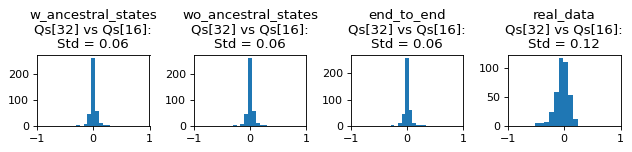

*************** #families = 32 ***************


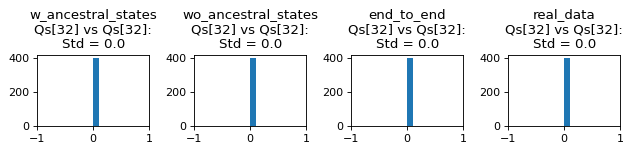

In [5]:
from statistics import stdev

def relative_errors(Q_true, Q_estimated, mask = None):
    assert(Q_true.shape == Q_estimated.shape)
    if mask is None:
        mask = (np.ones(shape=Q_true.shape) == 1)
    relative_errors = np.log(Q_estimated[mask] / Q_true[mask])
    return relative_errors

def _plot_convergence_to_self(learned_rate_matrices, max_families, max_families_list, title):
    re = relative_errors(learned_rate_matrices[max_families_list[-1]], learned_rate_matrices[max_families])
    plt.hist(re)
    plt.title(f"{title}\nQs[{max_families_list[-1]}] vs Qs[{max_families}]:\nStd = {str(stdev(re))[:4]}")
    plt.xlim([-1, 1])

def plot_convergence_to_self():
    for max_families in max_families_list:
        print("*" * 15 + f" #families = {max_families} " + "*" * 15)
        for normalize in [True]:
            figure(figsize=(8, 2), dpi=80)
            plt.subplot(1, 4, 1)
            _plot_convergence_to_self(learned_rate_matrices['w_ancestral_states'], max_families, max_families_list, title='w_ancestral_states')
            plt.subplot(1, 4, 2)
            _plot_convergence_to_self(learned_rate_matrices['wo_ancestral_states'], max_families, max_families_list, title='wo_ancestral_states')
            plt.subplot(1, 4, 3)
            _plot_convergence_to_self(learned_rate_matrices['end_to_end'], max_families, max_families_list, title='end_to_end')
            plt.subplot(1, 4, 4)
            _plot_convergence_to_self(learned_rate_matrices['real_data'], max_families, max_families_list, title='real_data')
            plt.tight_layout()
            plt.show()

plot_convergence_to_self()